<a href="https://colab.research.google.com/github/andygma567/Portfolio-Project-4-Lightning-Experiment/blob/main/Unfinished_Keras_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO DO:

- Later include a reference for the sizes of the conv2d transpose

- I need to test the checkpoint and model saving... also I want to run this with pokemon datasets
- Think about adding in a FID scorer in order to compare my GANs

- It really doesn't work on this pokemon dataset... After about an hour it doesn't produce anything besides a solid black photo

- I'd like to see if my faces GAN works... It might be easier for me to approximate the 16bit sun and moon characters... I do worry that the discriminator was becoming too good by the end... 
- It could also be because I used pooling after convolutions...?

Later: 
- mention that regularization is like instance noise and the type R1 shows a comparable performance in some examples
- mention the two ways to do the optimizer update
- mention the R1 - type regularization has an critical gamma 

I tried to use an R1 type regularization (with critical regularization parameter) along with one-sided label smoothing. 

I also wrote my own custom train step and a custom checkpoint in order to save the model as it runs.

Helpful resources

Code Examples
*   [DCGAN to generate face images](https://keras.io/examples/generative/dcgan_overriding_train_step/#create-a-callback-that-periodically-saves-generated-images)
*   [WGAN-GP overriding Model.train_step](https://keras.io/examples/generative/wgan_gp/#create-the-wgangp-model)
-   [TF DCGAN tutorial](https://www.tensorflow.org/tutorials/generative/dcgan)

Youtube Videos
- [Explaining how to figure out the upsampling parameters](https://youtu.be/ByjaPdWXKJ4?t=1019)
- [Interview with Kevin Roth discussing zero-centered GP](https://www.youtube.com/watch?v=pBUG8OI4uKw)

One-Sided Label Smoothing:
- [NIPS 2016 Tutorial:
Generative Adversarial Networks](https://arxiv.org/pdf/1701.00160.pdf)

Pokemon Dataset:
- [Pokemon Sprites](https://github.com/PokeAPI/sprites)

Gradient Penalties and convergence papers:
- https://arxiv.org/pdf/1801.04406.pdf
- https://arxiv.org/pdf/1705.09367.pdf
- https://arxiv.org/abs/1704.00028
- https://arxiv.org/pdf/1706.04156.pdf
- https://arxiv.org/pdf/1902.03984.pdf

It's also helpful to read the source code things from the people above. A lot of the source code on Github and the papers have links in them.  

## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import gdown
from zipfile import ZipFile

## Prepare Pokemon data

We'll use face images from the Pokemon dataset. I'll use the 'home' pokemon director which contains (512,512) images. 

In [ ]:
# if not pathlib.Path('sprites').exists():
#   ! git clone https://github.com/PokeAPI/sprites.git
# else:
#   print('File already exists in cwd')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if not pathlib.Path('size64').exists():
  !cp '/content/drive/MyDrive/anime-faces.zip' .
  !unzip -q "/content/anime-faces.zip"
else:
  print('File already exists in cwd')

# '/content/size64'

Create a dataset from our folder, and rescale the images to the [0-1] range. Batch size 32 gives me an 'Out of Memory' error so I changed it to batch size 10.

In [ ]:
# This is for the 512 images in other file 
# '/content/sprites/sprites/pokemon/other/home'
# This is for everything
# pokemon = '/content/sprites/sprites'
# Sun and Moon
# '/content/sprites/sprites/pokemon/versions/generation-vii'
# Emerald dataset
pokemon = '/content/sprites/sprites/pokemon/versions/generation-iii/emerald'

dataset = keras.utils.image_dataset_from_directory(
    directory = '/content/size64', 
    label_mode = None, 
    batch_size = 32, 
    image_size=(64, 64)
    )

Found 2434 files belonging to 1 classes.


In [ ]:
# I added this in to optimize my pipeline
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset \
          .map(lambda x: x / 255.0, 
          num_parallel_calls=tf.data.AUTOTUNE) \
          .cache().prefetch(buffer_size=AUTOTUNE)

Let's display some sample images:

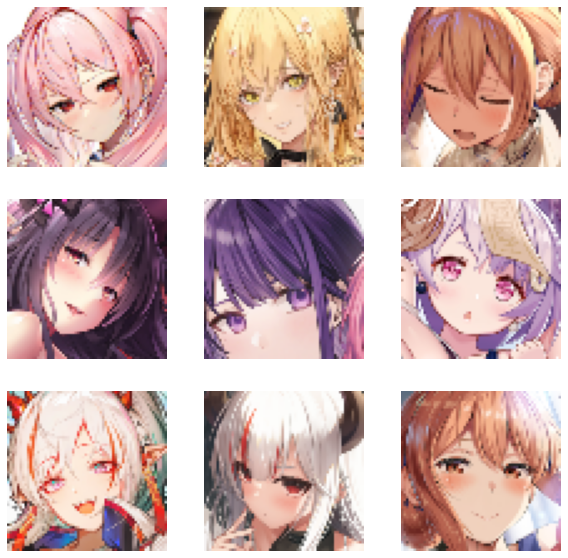

In [ ]:
plt.figure(figsize=(10, 10))

for x in dataset:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # print(x.shape)
    plt.imshow((x.numpy()* 255).astype("int32")[i])
    plt.axis("off")
  break

## Create the discriminator

It maps a 512x512 image to a binary classification score.

In [ ]:
# I read that it's better to use strided convolutions rather than maxpooling 
# For a discriminator

# This takes a (64,64) down to (8, 8)

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(), 
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_7 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                     

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [ ]:
latent_dim = 128

# outputs a 64 x 64 image
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_9 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 256)      52

## Override `train_step`



I tried to implement a non-saturating loss for the generator by following the way the BCE is implemented in tensorflow but I couldn't get it to work for me. 

When I try to take a gradient of this it keeps giving me no gradients so I don't know what's
going wrong here... 

I was following these notes:
- [A Stack Overflow post on this topic](https://stackoverflow.com/questions/67615051/implementing-binary-cross-entropy-loss-gives-different-answer-than-tensorflows)
- [See the TF implementation of Binary Cross Entropy here](https://github.com/keras-team/keras/blob/b80dd12da9c0bc3f569eca3455e77762cf2ee8ef/keras/backend.py#L5657)


Later I realized that I can use the prebuilt BCE loss function if I pass it labels of 1s. 

In [ ]:
# def make_g_loss(self, pred):
#   print(pred)
#   epsilon_ = tf.constant(1e-7)
#   clipped_pred = tf.clip_by_value(pred, epsilon_, 1.0 - epsilon_)
#   g_loss = tf.reduce_mean(tf.math.log(clipped_predictions + epsilon_), axis = 1)
#   return -g_loss

In [ ]:
# It looks like latenent dim is hardcoded into the generator
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        # This is regularization parameter
        # It is hardcoded because this is critical value for a Jensen-Shannon div
        # in order to make a locally non-rotational vector field
        # If we want to use a different f-divergence for the loss
        # Then we can change this value accordingly gamma_crit = 2|f'(0)|
        self.gamma = 1.0

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # This is a helper method for getting the gradient penalty
    # I don't make this a tf.function because it is only called by the train-step
    # and the train step will be graph executed so this will be recursively graph
    # executed
    def make_gp(self, real_images):
      # real images is originally a numpy array
      real_images = tf.convert_to_tensor(real_images)
      with tf.GradientTape() as tape:
        tape.watch(real_images)
        predictions = self.discriminator(real_images)
      # I want to take a gradient with respect to the dataset
      grads = tape.gradient(predictions, real_images)  
      # This is the euclidean-norm or l^2 norm for vectors
      regularizer = tf.reduce_mean(tf.math.square(tf.norm(grads, axis = 1))) 
      return (self.gamma * regularizer) / 2.0

    def train_step(self, real_images):
        #########################
        # Train the discriminator
        #########################
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        # I use one-sided label smoothing here - it's important to only do this
        # to the real labels
        labels = tf.concat(
            [tf.ones((batch_size, 1))*0.9, tf.zeros((batch_size, 1))], axis=0
        )
      
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
            penalty = self.make_gp(real_images)
            d_loss += penalty

        self.d_optimizer.minimize(d_loss, self.discriminator.trainable_weights, tape=tape)
        
        #####################
        # Train the generator
        #####################

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        # If I did this right with BCE then this should be the log D(G(z)) and I want to maximize this
        # i.e. minimize the negative and I think g_loss already comes with -log D(G(z)) so I can just minimize this
        self.g_optimizer.minimize(g_loss, self.generator.trainable_weights, tape=tape)

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Create a callback that periodically saves generated images

In [ ]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128, frequency=100):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
      if epoch % self.frequency == 1:
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255.0
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


## Checkpoint Callback to save my model's training

I used the information from these websites to learn how to use checkpoints for a GAN

1. [Saving a GAN in keras using tf.train.Checkpoint
](https://stackoverflow.com/questions/69988670/saving-a-gan-in-keras-using-tf-train-checkpoint#:~:text=Ordinarily%20in%20keras%20you'd,will%20not%20function%20as%20expected.)

2. https://www.tensorflow.org/tutorials/generative/dcgan#save_checkpoints

In [ ]:
# save checkpoints to my drive
checkpoint_path = "./training/ckpt"

Here I'm trying to make a custom callback in order to save my GAN... The standard Keras callback for ModelCheckpoint has trouble saving my custom model and it throws an error.

In [ ]:
# Create a custom callback that saves the GAN and the optimizers at every epoch
class GAN_checkpoint_maker(keras.callbacks.Callback):
  def __init__(self, frequency=100):  
    self.frequency = frequency

  def on_train_begin(self, logs=None):
    self.ckpt = tf.train.Checkpoint(g_optimizer=self.model.g_optimizer,
                                    d_optimizer=self.model.d_optimizer,
                                    generator=self.model.generator,
                                    discriminator=self.model.discriminator,
                                    )
    self.manager = tf.train.CheckpointManager(self.ckpt, "./training/ckpt", max_to_keep=1)

  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.frequency == 1:
     self.manager.save()
     print('\n I saved a checkpoint!')

### Restoring from a Checkpoint

I learned the following from the TF guides. You can execute the code below if you want to test deleting a gan, building a new gan, and resume training from a checkpoint. 

In [ ]:
# del gan

# new_gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
# new_gan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#     g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#     loss_fn=keras.losses.BinaryCrossentropy(),
# )

# ckpt = tf.train.Checkpoint()
# manager = tf.train.CheckpointManager(ckpt, '/content/training/ckpt', max_to_keep=1)
# status = ckpt.restore(manager.latest_checkpoint)

# # This is for checking that the restore worked
# status.assert_existing_objects_matched()

# # Resume training
# new_gan.fit(
#     dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim), GAN_checkpoint_maker()]
# )

## Train the end-to-end model

In [ ]:
# I want to add in a callback to checkpoint the model / generator
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# Save the GAN model

If I use this way of saving just the graph then I can save the generator and reuse it for the fixed shape input signatures but it won't work for me if I use new signatures and it doesn't save the python functions so I can't continue training the model. 

See 'Saving a Custom model' in the guide: https://www.tensorflow.org/guide/saved_model#loading_and_using_a_custom_model

I believe that it's possible to also use the Keras pre-built SavedModel format if I further subclass my custom model to have a __call__() method and an initialization (where I can build my generator and discriminator)... there was a TF guide or tutorial explaining this in detail somewhere. 

- https://www.tensorflow.org/guide/keras/save_and_serialize#how_to_save_and_load_a_model
- https://www.tensorflow.org/guide/saved_model#creating_a_savedmodel_from_keras

In [ ]:
# Keras always runs models in graph execution so now I use this to force it to run eagerly for debugging
tf.config.run_functions_eagerly(False)

# In practice, use ~100 epochs
# takes about 17min / epoch
epochs = 100
save_freq = 20
gan.fit(
    dataset, 
    epochs=epochs, 
    callbacks=[
        GANMonitor(num_img=3, latent_dim=latent_dim, frequency=save_freq), 
        GAN_checkpoint_maker(frequency=save_freq)
        ]
    )

Epoch 1/100
77/77 [==============================] - 108s 159ms/step - d_loss: 0.6019 - g_loss: 0.7220
Epoch 2/100
76/77 [============================>.] - ETA: 0s - d_loss: 0.3869 - g_loss: 1.2607
 I saved a checkpoint!
77/77 [==============================] - 12s 161ms/step - d_loss: 0.3841 - g_loss: 1.2836
Epoch 3/100
77/77 [==============================] - 12s 159ms/step - d_loss: 0.1987 - g_loss: 2.1660
Epoch 4/100
77/77 [==============================] - 12s 160ms/step - d_loss: 0.7835 - g_loss: 2.5164
Epoch 5/100
77/77 [==============================] - 12s 160ms/step - d_loss: 0.3359 - g_loss: 1.9371
Epoch 6/100
77/77 [==============================] - 12s 161ms/step - d_loss: 0.2899 - g_loss: 1.6968
Epoch 7/100
77/77 [==============================] - 12s 161ms/step - d_loss: 0.3846 - g_loss: 1.9032
Epoch 8/100
77/77 [==============================] - 12s 161ms/step - d_loss: 0.2918 - g_loss: 2.2331
Epoch 9/100
77/77 [==============================] - 12s 162ms/step - d_loss: